In [1]:
from itertools import chain
import numpy as np
from rdkit.Chem import PyMol, Draw, MolToSmiles

from pangea_case_study import get_features
from utils import load_mols, load_fepops

### Load Data

In [2]:
name_suffix = "500"
mols, tauts = load_mols(name_suffix=name_suffix)
fepops = load_fepops(name_suffix=name_suffix)

# flatten lists
mol_index = np.repeat(np.arange(len(tauts)), [len(t) for t in tauts])
tauts = np.array(list(chain(*tauts)))
fepops = np.array(list(chain(*fepops)))

### Define functions for similarity computation

In [ ]:
def corr(X, y):
    """
    Compute pearson correlation between X and y.

    Args:
        X: Input array with shape (N x T)
        y: Input array with shape (M x T)

    Returns:
        Matrix with shape (N x M) of correlation coefficients.
    """
    return X @ y.T / np.sqrt(np.sum(X ** 2, axis=1)[:, None] @ np.sum(y ** 2, axis=1)[None])


def remove_same_compounds(r, mol_index):
    """
    Clear the correlation matrix from similarities between the same compounds (but different tautomers).

    Args:
        r: Correlation matrix
        mol_index: index from tautomers to dataset compounds.
    """
    for mol_i in np.unique(mol_index):
        taut_i = np.where(mol_index==mol_i)[0]
        comb = [(x * 7, y * 7) for x in taut_i for y in taut_i if x <= y]
        for x, y in comb:
            r[x:x + 7, y:y + 7] = -1
            r[y:y + 7, x:x + 7] = -1


def fepops_similarity_matrix(fepops_matrix, mol_index):
    """
    Compute FEPOPS similarities between each compound in dataset

    Args:
        fepops_matrix: Matrix of FEPOPS descriptors.
        mol_index: index from tautomers to dataset compounds.

    Returns:
        r: Similarity matrix.
        best: Ranked indices of most similar compounds.
    """
    fepops_matrix = np.reshape(fepops_matrix, (-1, fepops_matrix.shape[-1]))
    fepops_matrix -= np.mean(fepops_matrix, axis=0)
    fepops_matrix /= np.std(fepops_matrix, axis=0)

    r = corr(fepops_matrix, fepops_matrix)
    remove_same_compounds(r, mol_index)
    r[np.tril_indices(r.shape[0])] = -1

    best = np.dstack(np.unravel_index(np.argsort(r.ravel()), r.shape))[0][::-1]
    return r, best


def get_most_similar_conformers(mol1, mol2):
    """
    Get the index of the most similar conformers of two molecules.

    Args:
        mol1: Molecule 1.
        mol2: Molecule 2.

    Returns:
        Tuple of the conformer indices.
    """
    feat1 = np.array(get_features(mol1))
    feat2 = np.array(get_features(mol2))
    feat1 = feat1 - np.mean(feat1, axis=0)
    feat2 = feat2 - np.mean(feat2, axis=0)
    r = corr(feat1, feat2)
    i, j = np.where(r == r.max())
    print(f"Conformer similarity {r.max():.2f}")
    return int(i), int(j)


def visualize_results_3d(mol_1, mol_2):
    """
    Visualize two molecules in PyMol.
    
    Args:
        mol_1: Molecule 1.
        mol_2: Molecule 2.
    """
    conf_id_1, conf_id_2 = get_most_similar_conformers(mol_1, mol_2)
    v= PyMol.MolViewer()
    v.DeleteAll()
    v.server.do('set grid_mode, on')
    v.ShowMol(mol_1, confId=conf_id_1, name="mol_1", showOnly=False)
    v.ShowMol(mol_2, confId=conf_id_2, name='mol_2', showOnly=False)

### Compute FEPOPS similarity matrix for whole dataset

In [6]:
r_matrix, best_ids = fepops_similarity_matrix(fepops, mol_index)

# for performance reasons, only create index for top 1% of results
top_1_percent = int(len(np.where(r_matrix > -1)[0]) * 0.01)
best_ids = best_ids[:top_1_percent]
best_ids_tauts = (best_ids // 7).tolist()
best_ids_mols = [[mol_index[taut1], mol_index[taut2]] for taut1, taut2 in best_ids_tauts]

### Display similarity matrix for a part of the dataset

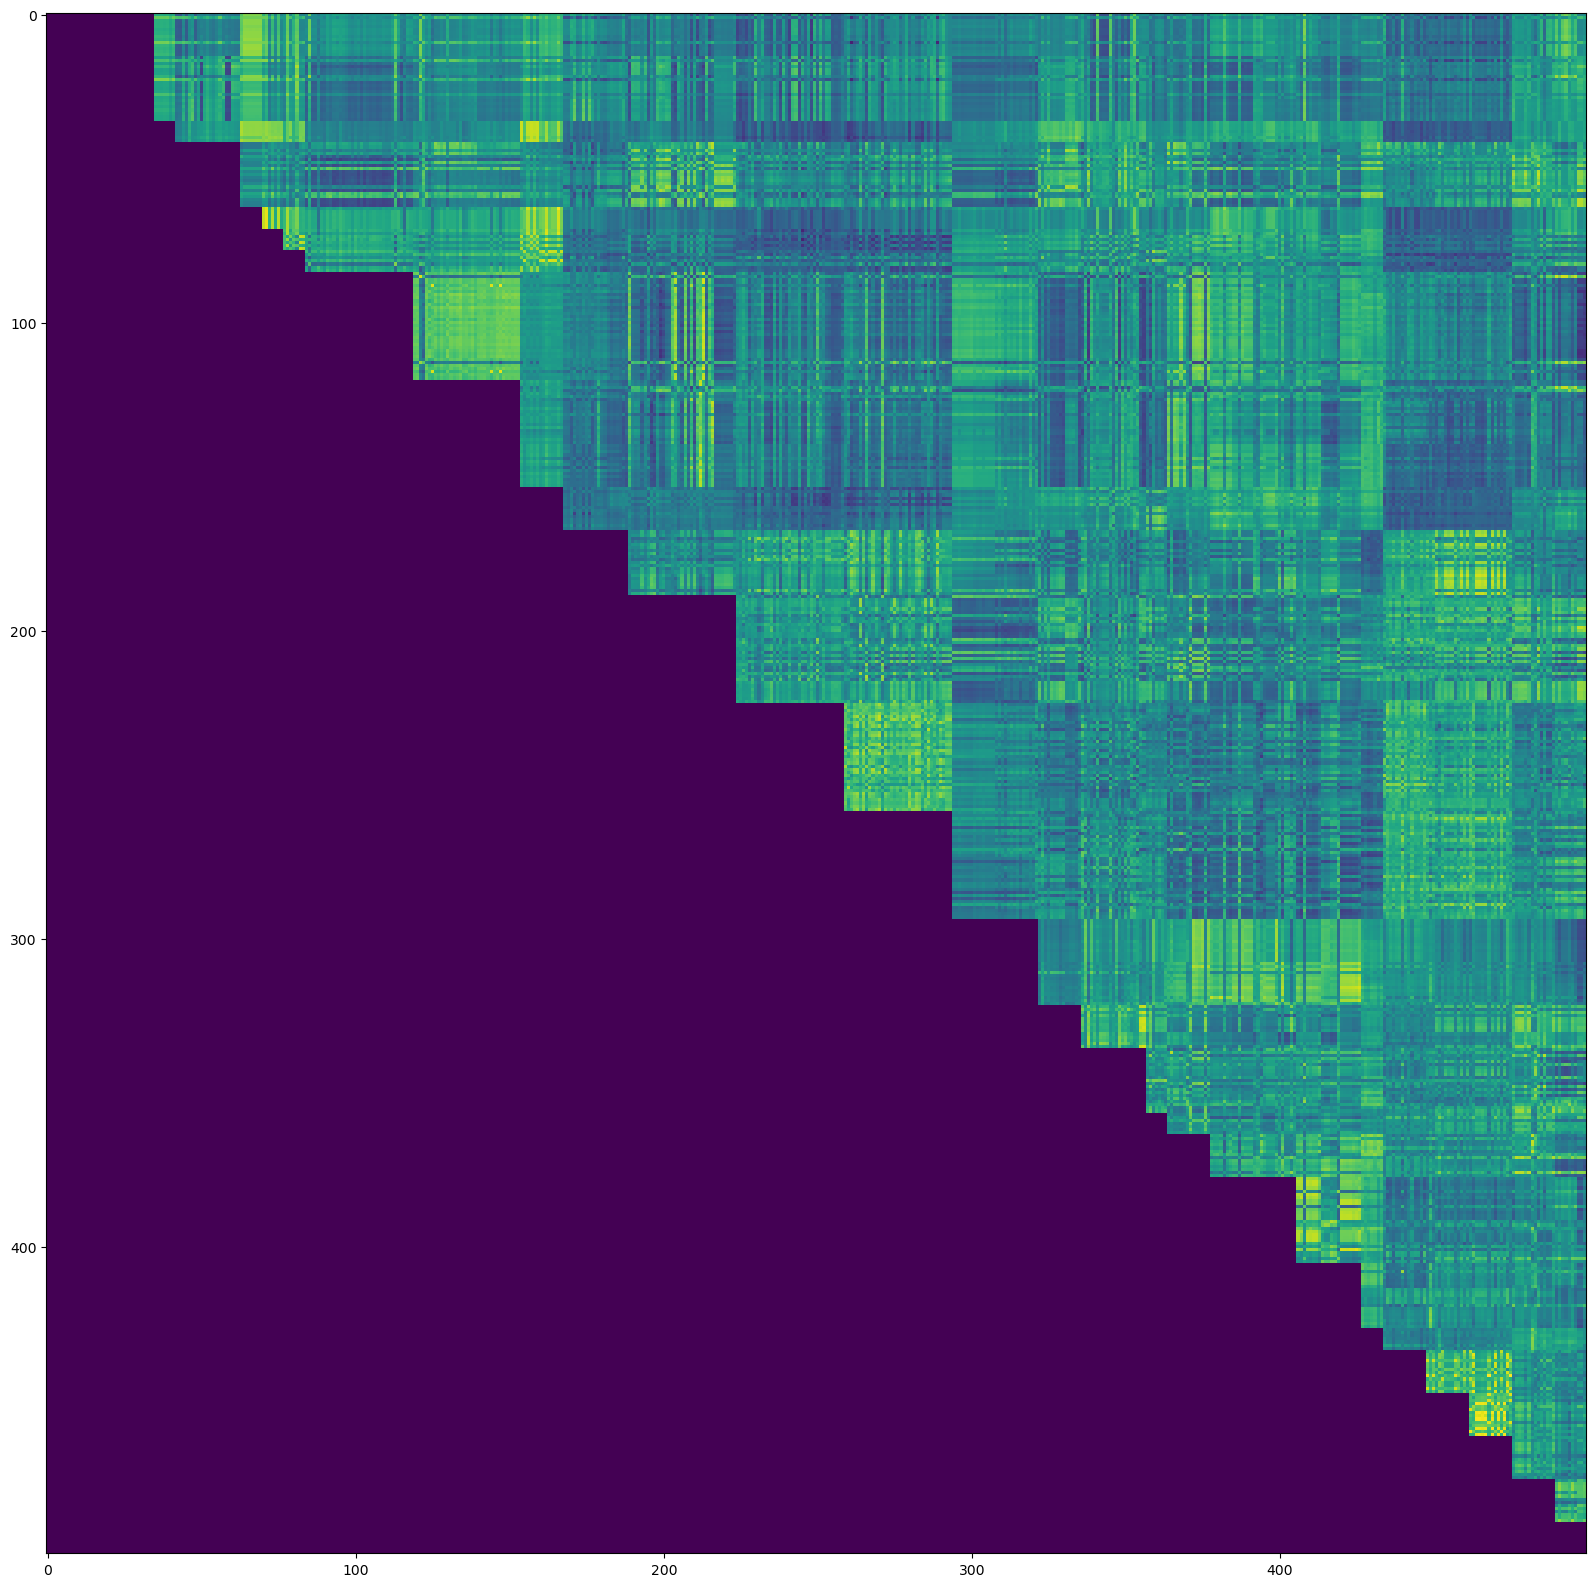

In [15]:
from utils import visualize_matrix

visualize_matrix(r_matrix)

### Show histogram of similarities

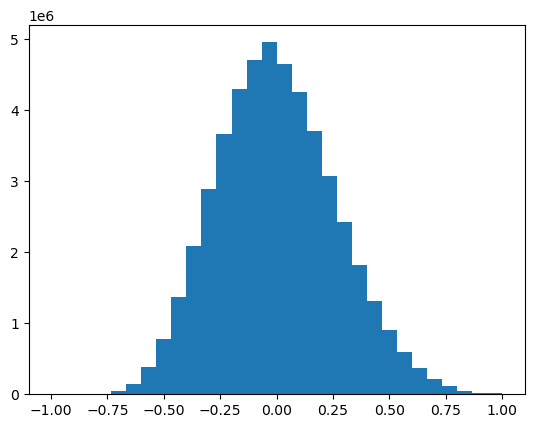

In [8]:
from utils import histogram_matrix

histogram_matrix(r_matrix)

In [13]:
def get_results():
    """
    Generator for results of similarities.
    
    Returns:
        Generator    
    """
    for (fep1, fep2), (taut_i_1, taut_i_2), (i, (mol_i_1, mol_i_2)) in zip(best_ids, best_ids_tauts, enumerate(best_ids_mols)):
        mol1 = mols[mol_i_1]
        mol2 = mols[mol_i_2]
        if MolToSmiles(mol1) == MolToSmiles(mol2):
            continue
        if best_ids_mols.index([mol_i_1, mol_i_2]) < i:
            continue
        print(f"Molecule {mol_i_1} and {mol_i_2}")
        print(f"Similarity = {r_matrix[fep1, fep2]:.4f}")
        yield mol1, mol2, tauts[taut_i_1], tauts[taut_i_2]

result_generator = get_results()

### Visualize 2D structure of next similarity pair

Molecule 193 and 304
Similarity = 1.0000


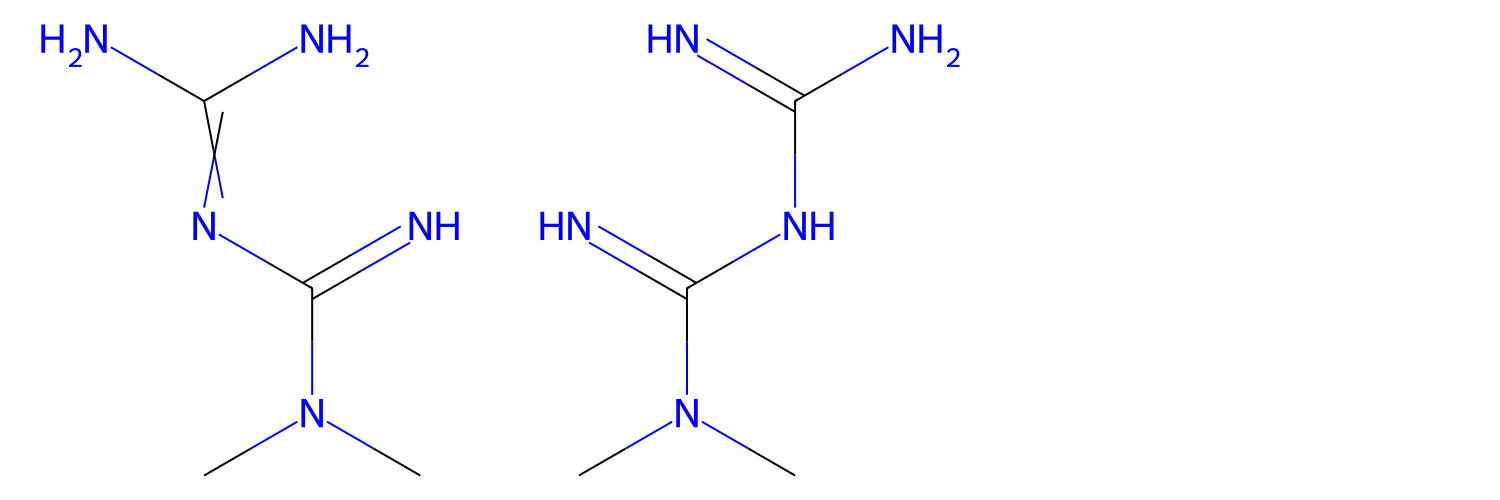

In [14]:
mol1, mol2, taut1, taut2 = next(result_generator)

Draw.MolsToGridImage([mol1, mol2], subImgSize=(500, 500))

### Show molecules in 3D with PyMol

In [16]:
visualize_results_3d(taut1, taut2)

Conformer similarity 1.00
